In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, f_regression
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import ks_2samp


In [2]:
# Cargar datos
df = pd.read_csv('../data/digital_wallet_ltv_dataset.csv')

In [3]:

# Calcular cortes por terciles para LTV
low_p = df['LTV'].quantile(0.33)
high_p = df['LTV'].quantile(0.66)
print(f"Terciles: 33% = {low_p:.2f}, 66% = {high_p:.2f}")

# Crear etiqueta categórica balanceada
df['LTV_cat'] = pd.cut(
    df['LTV'],
    bins=[-np.inf, low_p, high_p, np.inf],
    labels=['bajo', 'medio', 'alto']
)

# Ver distribución balanceada
print("Distribución LTV_cat:")
print(df['LTV_cat'].value_counts())


Terciles: 33% = 213350.98, 66% = 613131.72
Distribución LTV_cat:
LTV_cat
alto     2380
bajo     2310
medio    2310
Name: count, dtype: int64


In [4]:
import numpy as np
import pandas as pd


# Función auxiliar para WOE y IV de una sola variable
def calc_woe_iv(df, feature, target, bins=10):
    """
    df: DataFrame
    feature: nombre de la columna predictora (numérica)
    target: nombre de la columna binaria de evento (0/1), p.ej. y_bin o LTV_cat=='alto'
    bins: número de bins para discretizar la variable
    """
    # 1) Binning de la variable
    df_temp = df[[feature, target]].copy()
    df_temp['bin'] = pd.qcut(df_temp[feature], q=bins, duplicates='drop')

    # 2) Totales globales
    total_good = (df_temp[target] == 0).sum()
    total_bad = (df_temp[target] == 1).sum()

    # 3) Calcular stats por bin
    woe_dict = {}
    iv = 0
    grouped = df_temp.groupby('bin', observed=True)
    for grp_name, grp in grouped:
        good = (grp[target] == 0).sum()
        bad = (grp[target] == 1).sum()
        # evitar división por cero
        pct_good = good / total_good if total_good > 0 else 0
        pct_bad = bad / total_bad if total_bad > 0 else 0
        # WOE: log(pct_good / pct_bad)
        woe = np.log((pct_good + 1e-6) / (pct_bad + 1e-6))
        woe_dict[grp_name] = woe
        # acumular IV
        iv += (pct_good - pct_bad) * woe

    # Construir tabla
    woe_df = pd.DataFrame({
        'bin': list(woe_dict.keys()),
        'WOE': list(woe_dict.values())
    })
    return woe_df, iv


# Definir variable binaria automáticamente basado en la mediana de LTV
threshold = df['LTV'].median()
df['y_bin'] = (df['LTV'] > threshold).astype(int)

# Recorrer variables numéricas para WOE/IV
numeric_feats = df.select_dtypes(include=[np.number]).columns.drop(['LTV', 'y_bin'])
iv_summary = []

for feat in numeric_feats:
    try:
        woe_table, iv_val = calc_woe_iv(df, feat, 'y_bin', bins=10)
        iv_summary.append({'feature': feat, 'IV': iv_val})
        # Opcional: guardar o mostrar woe_table para inspeccionar
        print(f"\n--- {feat} ---")
        print(woe_table)
    except Exception as e:
        print(f"Error en {feat}: {e}")

# Resumen de IV
# Resumen de IV
iv_df = pd.DataFrame(iv_summary).sort_values(by='IV', ascending=False)
print("\nInformación Value (IV) de variables:")
print(iv_df)



--- Age ---
              bin       WOE
0  (15.999, 21.0]  0.041564
1    (21.0, 27.0]  0.002692
2    (27.0, 32.0]  0.114144
3    (32.0, 37.0] -0.081247
4    (37.0, 43.0]  0.100840
5    (43.0, 48.0] -0.186875
6    (48.0, 53.0]  0.011940
7    (53.0, 59.0]  0.008141
8    (59.0, 64.0]  0.008633
9    (64.0, 69.0] -0.053725

--- Total_Transactions ---
               bin        WOE
0   (0.999, 103.9]  12.206078
1   (103.9, 203.0]   4.755881
2   (203.0, 304.0]   1.028070
3   (304.0, 408.6]   0.046385
4   (408.6, 506.0]  -0.344266
5   (506.0, 599.0]  -0.545109
6   (599.0, 696.0]  -0.860931
7   (696.0, 797.0]  -1.045657
8   (797.0, 899.0]  -1.266477
9  (899.0, 1000.0]  -1.417271

--- Avg_Transaction_Value ---
                      bin        WOE
0      (10.185, 2071.745]  12.206078
1    (2071.745, 3940.493]  12.206078
2    (3940.493, 5870.101]   1.449990
3    (5870.101, 7811.039]   0.148844
4    (7811.039, 9841.173]  -0.358059
5   (9841.173, 11931.532]  -0.701723
6  (11931.532, 14016.355]  -0.9

In [5]:
import pandas as pd

# Filtrar features con IV significativo (por ejemplo IV > 0.1)
good_feats = iv_df[iv_df['IV'] > 0.1]['feature'].tolist()
print("Features seleccionados para WOE:", good_feats)

# Crear columnas WOE para cada feature
for feat in good_feats:
    woe_table, _ = calc_woe_iv(df, feat, 'y_bin', bins=10)
    # Asignar bins y mapear a WOE
    df[f'{feat}_bin'] = pd.qcut(df[feat], q=10, duplicates='drop')
    mapping = dict(zip(woe_table['bin'], woe_table['WOE']))
    df[f'WOE_{feat}'] = df[f'{feat}_bin'].map(mapping).astype(float)

# Definir nuevo X_sel basado en WOE
woe_feats = [f'WOE_{f}' for f in good_feats]
X_sel = df[woe_feats]
print("Nuevo X_sel con WOE:", X_sel.shape)
print("Columns:", woe_feats)

Features seleccionados para WOE: ['Total_Spent', 'Avg_Transaction_Value', 'Total_Transactions', 'Min_Transaction_Value', 'Max_Transaction_Value']
Nuevo X_sel con WOE: (7000, 5)
Columns: ['WOE_Total_Spent', 'WOE_Avg_Transaction_Value', 'WOE_Total_Transactions', 'WOE_Min_Transaction_Value', 'WOE_Max_Transaction_Value']


In [6]:
# Verificar nombres de columnas
print("Columnas disponibles:", df.columns.tolist())


Columnas disponibles: ['Customer_ID', 'Age', 'Location', 'Income_Level', 'Total_Transactions', 'Avg_Transaction_Value', 'Max_Transaction_Value', 'Min_Transaction_Value', 'Total_Spent', 'Active_Days', 'Last_Transaction_Days_Ago', 'Loyalty_Points_Earned', 'Referral_Count', 'Cashback_Received', 'App_Usage_Frequency', 'Preferred_Payment_Method', 'Support_Tickets_Raised', 'Issue_Resolution_Time', 'Customer_Satisfaction_Score', 'LTV', 'LTV_cat', 'y_bin', 'Total_Spent_bin', 'WOE_Total_Spent', 'Avg_Transaction_Value_bin', 'WOE_Avg_Transaction_Value', 'Total_Transactions_bin', 'WOE_Total_Transactions', 'Min_Transaction_Value_bin', 'WOE_Min_Transaction_Value', 'Max_Transaction_Value_bin', 'WOE_Max_Transaction_Value']


In [7]:
# Imprimir nombres y datos de las primeras 5 columnas
primeras_cols = df.columns[:20]
print("Nombres de las primeras columnas:", primeras_cols.tolist())
print("\nPrimeras filas de esas columnas:")
print(df.iloc[:, :5].head())


Nombres de las primeras columnas: ['Customer_ID', 'Age', 'Location', 'Income_Level', 'Total_Transactions', 'Avg_Transaction_Value', 'Max_Transaction_Value', 'Min_Transaction_Value', 'Total_Spent', 'Active_Days', 'Last_Transaction_Days_Ago', 'Loyalty_Points_Earned', 'Referral_Count', 'Cashback_Received', 'App_Usage_Frequency', 'Preferred_Payment_Method', 'Support_Tickets_Raised', 'Issue_Resolution_Time', 'Customer_Satisfaction_Score', 'LTV']

Primeras filas de esas columnas:
  Customer_ID  Age  Location Income_Level  Total_Transactions
0   cust_0000   54     Urban          Low                 192
1   cust_0001   67  Suburban         High                 979
2   cust_0002   44     Urban         High                 329
3   cust_0003   30     Rural         High                  71
4   cust_0004   58     Urban       Middle                 878


In [8]:
print("Tipos de datos por columna:")
print(df.dtypes)


Tipos de datos por columna:
Customer_ID                      object
Age                               int64
Location                         object
Income_Level                     object
Total_Transactions                int64
Avg_Transaction_Value           float64
Max_Transaction_Value           float64
Min_Transaction_Value           float64
Total_Spent                     float64
Active_Days                       int64
Last_Transaction_Days_Ago         int64
Loyalty_Points_Earned             int64
Referral_Count                    int64
Cashback_Received               float64
App_Usage_Frequency              object
Preferred_Payment_Method         object
Support_Tickets_Raised            int64
Issue_Resolution_Time           float64
Customer_Satisfaction_Score       int64
LTV                             float64
LTV_cat                        category
y_bin                             int64
Total_Spent_bin                category
WOE_Total_Spent                 float64
Avg_Transact

In [9]:
num_dup = df.duplicated().sum()
print("Número de filas duplicadas:", num_dup)
if num_dup > 0:
    print("\nEjemplo de filas duplicadas:")
    print(df[df.duplicated()].head())


Número de filas duplicadas: 0


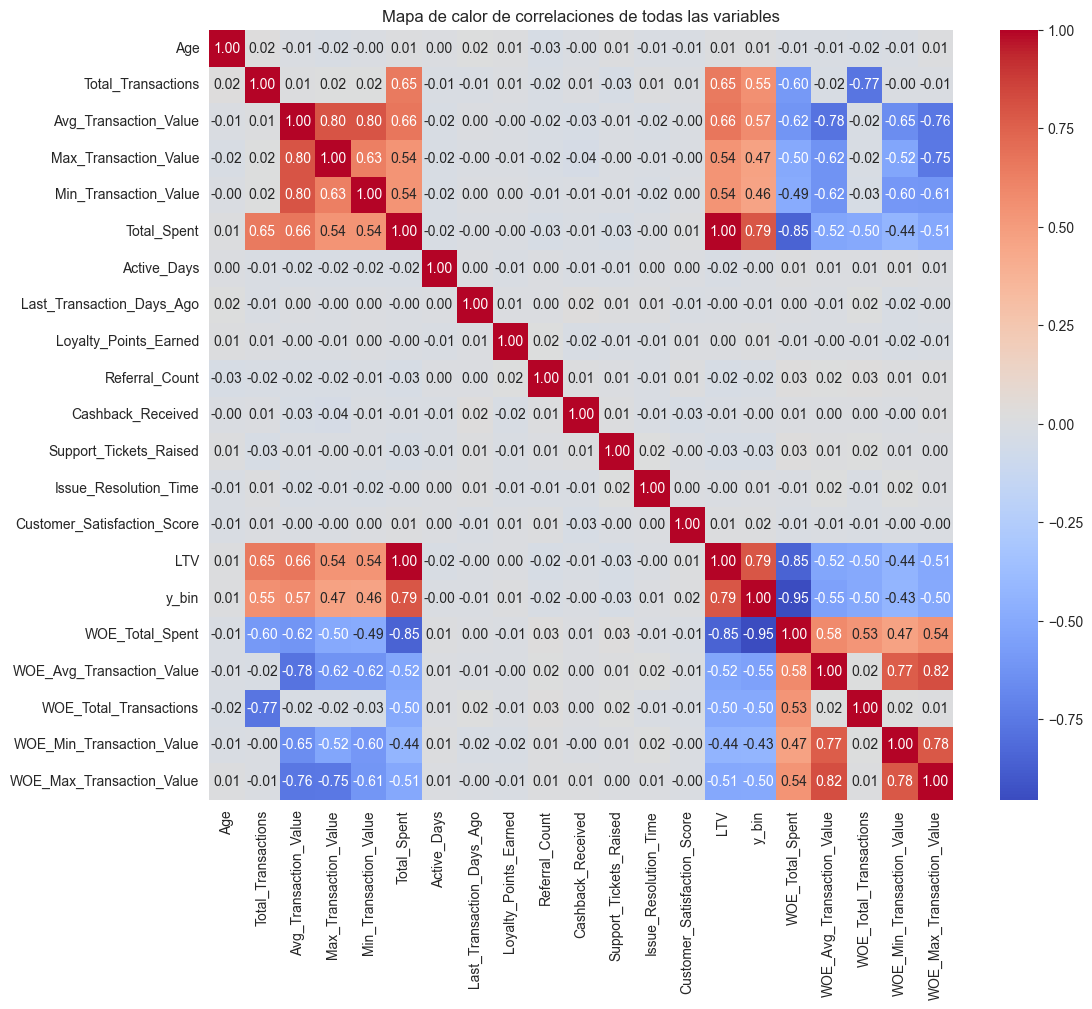

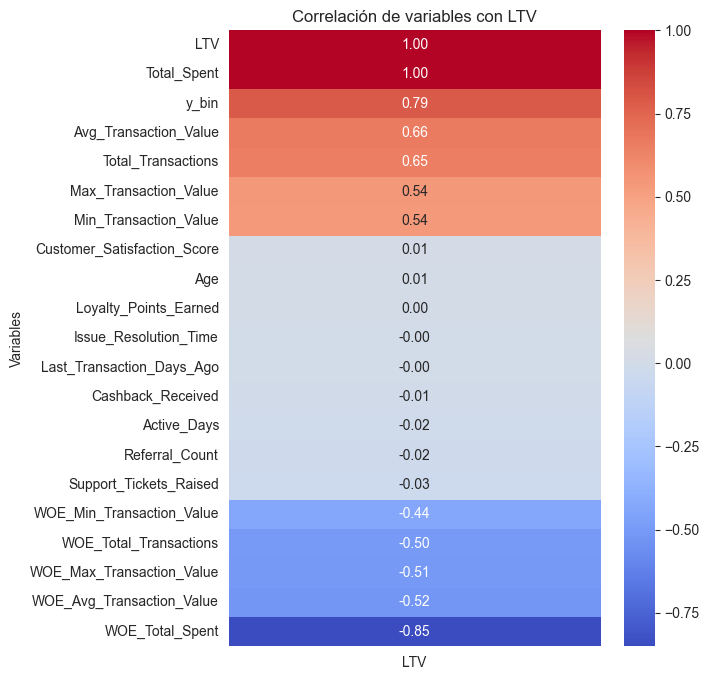

In [10]:

# Seleccionar solo columnas numéricas
numeric_df = df.select_dtypes(include=[np.number])

# Calcular matriz de correlación completa
corr_matrix = numeric_df.corr()

# Graficar heatmap completo
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Mapa de calor de correlaciones de todas las variables")
plt.show()

# Graficar correlación de cada variable con LTV
corr_ltv = corr_matrix[['LTV']].sort_values(by='LTV', ascending=False)
plt.figure(figsize=(6, 8))
sns.heatmap(corr_ltv, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlación de variables con LTV")
plt.ylabel("Variables")
plt.show()


In [11]:
 # Detectar columnas categóricas (excluyendo variables derivadas del target)
all_cat = df.select_dtypes(include=['object', 'category']).columns.tolist()
exclude = ['LTV_cat', 'LTV_opt_cat', 'y_bin']
cat_cols = [c for c in all_cat if c not in exclude]
print("Columnas categóricas detectadas:", cat_cols)

# One-hot encoding (drop_first=True)
df_cat = pd.get_dummies(df[cat_cols], drop_first=True)
# Asegurar no incluir columnas de target
df_cat = df_cat.loc[:, ~df_cat.columns.str.contains('LTV_cat|y_bin')]

# Recrear X_sel incluyendo numéricas y las dummies
# Usar las variables WOE seleccionadas
X_num = df[woe_feats]
X_sel = pd.concat([X_num, df_cat], axis=1)

# Volver a definir y
y = df['LTV']

# (Opcional) Verifica la nueva forma de X_sel
print("Nueva forma de X_sel:", X_sel.shape)
print("Primeras columnas de X_sel:", X_sel.columns[:10].tolist())

Columnas categóricas detectadas: ['Customer_ID', 'Location', 'Income_Level', 'App_Usage_Frequency', 'Preferred_Payment_Method', 'Total_Spent_bin', 'Avg_Transaction_Value_bin', 'Total_Transactions_bin', 'Min_Transaction_Value_bin', 'Max_Transaction_Value_bin']
Nueva forma de X_sel: (7000, 7058)
Primeras columnas de X_sel: ['WOE_Total_Spent', 'WOE_Avg_Transaction_Value', 'WOE_Total_Transactions', 'WOE_Min_Transaction_Value', 'WOE_Max_Transaction_Value', 'Customer_ID_cust_0001', 'Customer_ID_cust_0002', 'Customer_ID_cust_0003', 'Customer_ID_cust_0004', 'Customer_ID_cust_0005']


In [12]:
# Asegurar que y_bin esté definido
y_bin = df['y_bin']

from sklearn.feature_selection import SelectKBest, chi2

# Usar X_sel (todas las dummies y numéricas)
X_cls = X_sel.copy()

# Asegurar que no haya valores negativos antes de chi2
X_cls_positive = X_cls - X_cls.min() + 1e-6

# Seleccionar las 5 mejores características según chi-cuadrado
selector_cls = SelectKBest(score_func=chi2, k=5)
selector_cls.fit(X_cls_positive, y_bin)

# Listar las variables seleccionadas
selected_cls = X_cls.columns[selector_cls.get_support()].tolist()
print("Características seleccionadas para clasificación:", selected_cls)

# Reducir X_cls a esas variables para el modelo logístico
X_cls = X_cls[selected_cls]

TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

In [14]:
# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_sel, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

# Realizar predicciones
y_pred = model.predict(X_test)

# Evaluar el modelo
print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")
print(f"R²: {r2_score(y_test, y_pred):.4f}")

MSE: 24698100810.8149
R²: 0.8732


In [13]:
# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_sel, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo de regresión múltiple
model = LinearRegression()
model.fit(X_train, y_train)

# Realizar predicciones y guardar métricas
y_pred = model.predict(X_test)
mse_mult = mean_squared_error(y_test, y_pred)
r2_mult = r2_score(y_test, y_pred)
print(f"Regresión múltiple -> MSE: {mse_mult:.4f}, R²: {r2_mult:.4f}")

# Usar la variable más correlacionada
feature = relevantes[0]
X_simple = df[[feature]]
y = df['LTV']

# Dividir datos
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_simple, y, test_size=0.2, random_state=42)

# Entrenar modelo simple
model_s = LinearRegression()
model_s.fit(X_train_s, y_train_s)

# Predecir y evaluar
y_pred_s = model_s.predict(X_test_s)
mse_s = mean_squared_error(y_test_s, y_pred_s)
r2_s = r2_score(y_test_s, y_pred_s)
print(f"Regresión simple usando '{feature}' -> MSE: {mse_s:.4f}, R²: {r2_s:.4f}")

# Comparación de métricas
print("\nComparación de modelos:")
print(f"Múltiple: MSE={mse_mult:.4f}, R²={r2_mult:.4f}")
print(f"Simple:   MSE={mse_s:.4f}, R²={r2_s:.4f}")

Regresión múltiple -> MSE: 5132924486.1157, R²: 0.9736


NameError: name 'relevantes' is not defined

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

# Dividir usando las variables seleccionadas para clasificación (X_cls) y la etiqueta binaria
X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(
    X_cls, df['y_bin'], test_size=0.2, random_state=42
)

# Estandarizar Features
scaler = StandardScaler()
X_train_l = scaler.fit_transform(X_train_l)
X_test_l = scaler.transform(X_test_l)

# Entrenar regresión logística
logreg = LogisticRegression(max_iter=5000)
logreg.fit(X_train_l, y_train_l)

# Predecir y evaluar
y_pred_l = logreg.predict(X_test_l)
y_prob_l = logreg.predict_proba(X_test_l)[:, 1]
print(f"Accuracy: {accuracy_score(y_test_l, y_pred_l):.4f}")
print(f"AUC:      {roc_auc_score(y_test_l, y_prob_l):.4f}")

Accuracy: 0.9971
AUC:      0.9995


In [21]:

# KS para regresión lineal múltiple (predicciones vs valores reales)
ks_mult = ks_2samp(y_test, y_pred).statistic
print(f"KS regresión múltiple: {ks_mult:.4f}")

# KS para regresión lineal simple
ks_simple = ks_2samp(y_test_s, y_pred_s).statistic
print(f"KS regresión simple: {ks_simple:.4f}")

# KS para regresión logística (comparando distribuciones de probabilidades)
ks_logistic = ks_2samp(
    y_prob_l[y_test_l == 1],
    y_prob_l[y_test_l == 0]
).statistic
print(f"KS regresión logística: {ks_logistic:.4f}")

KS regresión múltiple: 0.1343
KS regresión simple: 0.2271
KS regresión logística: 0.9942


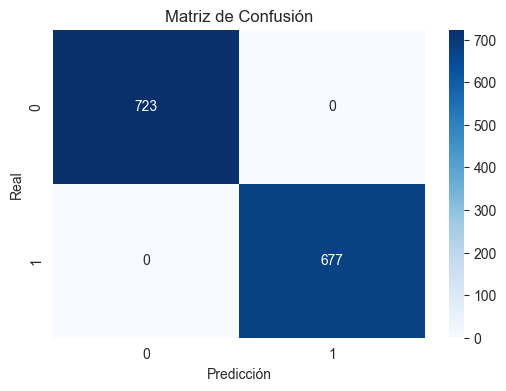

Precision: 1.0000
Recall:    1.0000
F1-score:  1.0000


In [18]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Matriz de confusión
cm = confusion_matrix(y_test_l, y_pred_l)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

# Métricas adicionales
precision = precision_score(y_test_l, y_pred_l)
recall = recall_score(y_test_l, y_pred_l)
f1 = f1_score(y_test_l, y_pred_l)
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")

In [19]:
from sklearn.tree import DecisionTreeRegressor
import numpy as np
import pandas as pd

# Ajustar árbol para encontrar 3 hojas (2 cortes)
dt = DecisionTreeRegressor(max_leaf_nodes=3, random_state=42)
dt.fit(X_sel, df['LTV'])

# Extraer umbrales de los nodos (excluyendo los “-2” que indican hojas)
tree = dt.tree_
thresholds = sorted(tree.threshold[tree.threshold != -2.0])
t_low, t_high = thresholds[:2]
print(f"Umbrales óptimos: {t_low:.2f}, {t_high:.2f}")

# Crear categoría usando esos cortes
df['LTV_opt_cat'] = pd.cut(
    df['LTV'],
    bins=[-np.inf, t_low, t_high, np.inf],
    labels=['bajo', 'medio', 'alto']
)

# Ver conteos
print(df['LTV_opt_cat'].value_counts())

Umbrales óptimos: -8.17, 679.50
LTV_opt_cat
alto     7000
bajo        0
medio       0
Name: count, dtype: int64
